# Causal Machine Learning
What follows is a series of exercises by an economics PhD student on a quest to sharpen her econ coding skills - this time: Causal Machine Learning - with a lot of help from ChatGPT.

This notebook contains the following:


1.   [Visualizing Trees](#causal_tree)  
2.   [Honest Tree](#ht)
3.   [Feature Importance in causal ML models](#feature_importance)
4.   [Estimating heterogenous treatment effects (HTE) using the `econml` package](#hte)

I have in mind to add the following in future:


*   More HTE estimation
*   Honest trees (Honest anything!)
*   Inference


Feel free to reach me at zkhnl@uw.edu and check out more totally amateur tutorials at [my GitHub](https://github.com/zahrakhanalizade/econ_coding)

## Installing and Dependency Shenanigans

Basically you need to install econml, but econml can be a bit picky about its friends (a.k.a dependencies). So you might have to deal with those before proceeding to the actual work. (You can do it, I believe in you!) Examples of some shenanigans I had to pull for econml to work can be found as comments in the below cell; feel free to ignore them.

In [ ]:
# Install econml (runs only if not already installed)
try:
    import econml
except ModuleNotFoundError:
    !pip install econml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [ ]:
# (Basically these are because the econml package wouldn't run on newer versions of certain packages so I had to downgrade them.)

# pip install --force-reinstall scikit-learn==1.5.0
#!pip install --force-reinstall numpy==1.26.4
# import sklearn
# import econml
# import numpy
# print("scikit-learn version:", sklearn.__version__)
# print("econml version:", econml.__version__)
# print("numpy version:", numpy.__version__)



  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


# Data Context:
Below I'll first give a quick rundown of the handy dandy OHDP dataset we'll be using and then shortly we'll do some real causal ML work!

## The IHDP (Infant Health and Development Program) Dataset

The IHDP dataset is a well-known benchmark for causal inference tasks. It simulates a real-world setting where treatment effects vary based on observed covariates.

## About the IHDP Dataset
**Context:** The dataset comes from a real clinical trial studying the effects of home visits on cognitive test scores for infants with low birth weight.

**Outcome (Y):** Cognitive score at age 3.

**Treatment (T):** Whether the child received the home visit intervention (binary).

**Covariates (X):** Child and mother demographics such as birth weight, mother’s education, and more.

**True Treatment Effect (τ):** The true effect is known, making this dataset ideal for testing causal models.

In [ ]:
# Load the IHDP dataset
url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
data = pd.read_csv(url)

In [ ]:
col = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"]
for i in range(1, 26):
    col.append(f"x{i}")
data.columns = col
data = data.astype({"treatment": 'bool'}, copy=False)
data.head()


,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
1,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
2,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
3,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
4,False,4.762090,8.264795,4.707898,7.219442,0.467901,-0.202946,-0.733261,0.161703,0.058500,...,1,1,1,1,0,0,0,0,0,0


In [ ]:
print(data.shape)

(746, 30)


In [ ]:
# Extract features, treatment, and outcome

# Drop 'treatment', 'y_factual', and 'y_cfactual' from covariates
X = data.drop(['treatment', 'y_factual', 'y_cfactual'], axis=1).values
T = data['treatment'].values
Y = data['y_factual'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.3, random_state=42
)

# Create a DataFrame for compatibility with econml's CausalForestDML
df = pd.DataFrame(X_train, columns=[f"x{i}" for i in range(1, 26)] + ["mu0", "mu1"])
df['Y'] = Y_train
df['D'] = T_train


<a name="causal_tree"></a>
# 1. 🌳 Visualizing a Causal Tree with `econml`

The code above demonstrates how to use the **`econml`** package to fit and visualize a **Causal Tree** — a powerful tool for estimating and interpreting **heterogeneous treatment effects**.


In [ ]:
### 🔎 Step 1: Fitting a Causal Tree Model
from econml.dml import CausalForestDML

# Fit a Causal Tree (with only 1 tree to mimic an honest tree)
tree_model = CausalForestDML(
    n_estimators=1,          # Single tree
    subforest_size=1,        # Single tree in the sub-forest
    inference=False,         # Skip inference to focus on tree structure
    max_depth=4              # Limit tree depth for better visualization
)
tree_model = tree_model.fit(Y=df['Y'], X=df.drop(['Y', 'D'], axis=1), T=df['D'])


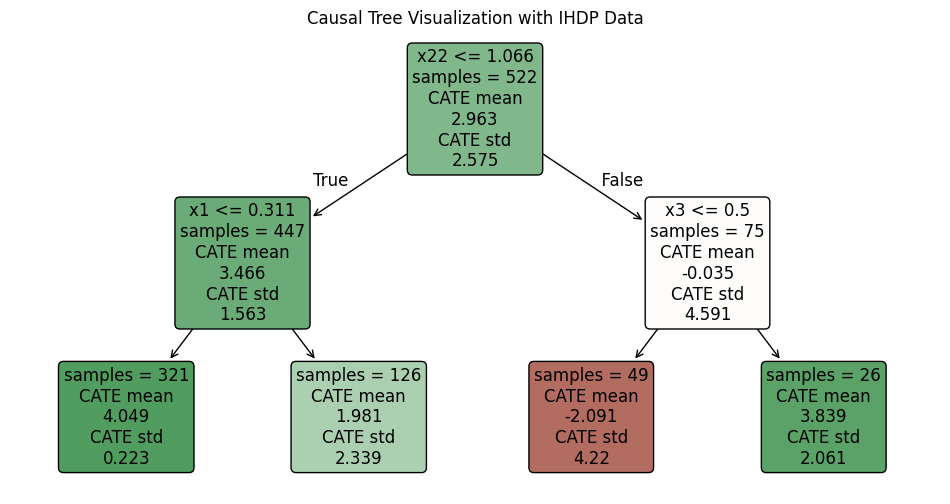

In [ ]:
# 🔎 Step 2: Visualizing the Causal Tree
from econml.cate_interpreter import SingleTreeCateInterpreter
import matplotlib.pyplot as plt

# Visualize the simplified causal tree
intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df.drop(['Y', 'D'], axis=1))

plt.figure(figsize=(12, 6))
intrp.plot(feature_names=df.drop(['Y', 'D'], axis=1).columns, fontsize=12)
plt.title("Causal Tree Visualization with IHDP Data")
plt.show()

<a name="ht"></a>

# 2. Honest Trees

Honest trees provide a solution to the bias introduced when the same data is used to both construct and evaluate a decision tree. This bias arises because the tree's partitions are **endogenous**, meaning they are based on the same data that will later be evaluated. This is a form of **overfitting**.

### 🔍 How Do Honest Trees Work?
To reduce this bias, honest trees follow a simple yet effective strategy:  

1. **Split the data into two independent subsamples:**  
   - One sample is used to **construct the tree's structure** (splits and partitions).  
   - The other sample is used to **evaluate outcomes** or **estimate treatment effects** within those partitions.  

This separation ensures that the sample used for evaluation is **independent** of the tree's structure, allowing us to apply the **Central Limit Theorem** for inference confidently.

### ⚠️ Drawback and Solution
- **Drawback:** Splitting the data reduces the effective sample size, potentially lowering the power to detect meaningful effects.  
- **Solution:** To recover some of this lost power:
   - Repeat the procedure by swapping the roles of the two subsamples.  
   - Average the two resulting estimates for each individual.  
   - Adjust the standard errors accordingly to account for this averaging.

Honest trees strike a balance between reducing bias and maintaining statistical power, making them particularly useful in **causal inference** and **heterogeneous treatment effect estimation**.


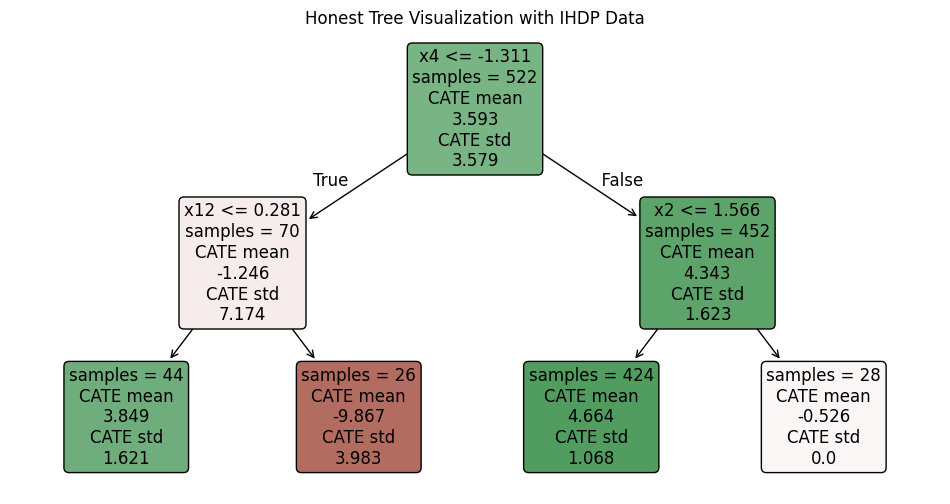

In [ ]:
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Honest Tree Estimator
honest_tree = CausalForestDML(
    n_estimators=1,          # Single tree (mimics an honest tree)
    subforest_size=1,        # Ensures only one tree is trained
    inference=False,         # Skip inference to focus on tree structure
    max_depth=4              # Limit tree depth for better interpretability
)

# Fit the Honest Tree (Splitting the dataset for "honesty")
honest_tree.fit(
    Y_train, T_train, X=X_train, W=None
)

# Visualizing the Honest Tree
intrp = SingleTreeCateInterpreter(max_depth=2)  # Limit depth for cleaner visualization
intrp.interpret(honest_tree, X_train)

# Plot the tree
plt.figure(figsize=(12, 6))
intrp.plot(feature_names=[f"x{i}" for i in range(1, 26)], fontsize=12)
plt.title("Honest Tree Visualization with IHDP Data")
plt.show()


## Considerations on Honest Tree results vs plain old decision tree:

The tree will show:


*   Splits based on the covariates (features).
*   Each leaf node will display the estimated treatment effect for observations in that partition.


Since honest trees separate data for training and evaluation, these estimates will be **more unbiased** than a typical decision tree.

<a name="feature_importance"></a>

# 3. Feature importance in causal ML models

**Feature importance** is a common concept in machine learning that measures how much each feature contributes to a model’s predictions. In standard models, it reflects how influential a feature is in predicting the outcome.

In the context of **causal inference**, feature importance takes on a slightly different role. For example, in Causal Forests, feature importance measures how much each feature contributes to the estimation of **heterogeneous treatment effects (HTEs)**. This is especially useful for identifying which features drive variations in causal effects across the population.

Think of it as a detective tool for spotting the key players behind treatment effect differences — crucial for understanding **why** some individuals or groups respond better (or worse) to an intervention.

**Why Does This Matter?**
For example, in a marketing study, feature importance can reveal which user characteristics — like age, location, or purchase history — most influence how a treatment (e.g., a coupon) impacts purchasing behavior.

⚠️ **Careful** when interpreting the results of feature importance:

**Higher feature importance ≠ Higher effect size**

Feature importance only tells you which features help predict variation in treatment effects — not necessarily which features have **large causal effects** themselves.

In other words, a feature might be important because it’s a strong predictor of **where** the effect varies, not because it directly drives the treatment effect.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML

# Simulated data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 5))  # Features
T = np.random.binomial(1, 0.5, size=n)   # Treatment assignment
y = 1 + 2 * T + np.dot(X, [0.5, -0.2, 0.1, 0, 0]) + np.random.normal(0, 1, size=n)  # Outcome

# Train/test split
X_train_s, X_test_s, T_train_s, T_test_s, y_train_s, y_test_s = train_test_split(X, T, y, test_size=0.2, random_state=42)

# Define the causal forest
causal_forest = CausalForestDML(
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    random_state=42
)

# Fit the model
causal_forest.fit(y_train_s, T_train_s, X=X_train_s)

# Compute feature importance
feature_importances = causal_forest.feature_importances_

# Display feature importance
for i, importance in enumerate(feature_importances):
    print(f"Feature {i + 1}: Importance = {importance:.4f}")


First stage model has discrete target but model is not a classifier!
First stage model has discrete target but model is not a classifier!


Feature 1: Importance = 0.2551
Feature 2: Importance = 0.2239
Feature 3: Importance = 0.1316
Feature 4: Importance = 0.1889
Feature 5: Importance = 0.2005


## Interpretation of Feature Importance Results

The feature importance results suggest that all five features contribute meaningfully to the estimated treatment effects, though some play a larger role than others.

Feature 1 (Importance = 0.2551) → The most influential feature. This feature drives the most variation in treatment effects across individuals.

**Key Takeaways**

✅ No single feature dominates. The relatively balanced importances suggest that multiple features jointly influence the treatment effect — a sign that the data has meaningful complexity.

✅ Feature 1 stands out slightly. It’s worth exploring this feature to understand why it’s driving treatment heterogeneity.

<a name="hte"></a>
#4. Estimating Heterogenous Treatment Effects (HTE)

## Estimating Conditional Average Treatment Effects (CATE)

Now let's get down to business — it's time to estimate some Conditional Average Treatment Effects (CATE) as we casually ease our way into the broader topic of heterogeneous treatment effects.

I'll be using the IHDP data again for this exercise.

In [ ]:
# Display data overview
df.head()


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x20,x21,x22,x23,x24,x25,mu0,mu1,Y,D
0,0.004647,0.248775,0.878064,0.995965,-0.732374,1.203249,0.308165,0.303601,-1.027179,-0.321792,...,0.193784,-0.393445,-0.395713,2.318635,-0.298414,-0.282125,-0.384308,-0.433472,5.926609,True
1,0.659656,0.899720,-1.370436,-1.802605,0.758352,0.161922,-0.442092,0.303601,-1.027179,-0.321792,...,0.193784,-0.393445,-0.395713,-0.431288,-0.298414,3.544522,-0.384308,-0.433472,4.455740,False
2,-0.494735,-0.421110,0.769963,0.196373,-1.477738,-0.879405,1.308508,-1.188621,0.973540,-0.321792,...,-5.160390,-0.393445,-0.395713,-0.431288,-0.298414,3.544522,-0.384308,-0.433472,1.811735,False
3,0.435478,0.697886,0.726722,0.596169,-0.359693,2.244576,-0.879742,0.303601,0.973540,-0.321792,...,0.193784,-0.393445,2.527081,-0.431288,-0.298414,-0.282125,-0.384308,-0.433472,2.945608,False
4,-0.952220,-1.289291,0.834823,0.596169,-1.105056,0.161922,0.870858,-1.686028,0.973540,-0.321792,...,0.193784,-0.393445,-0.395713,-0.431288,-0.298414,-0.282125,2.602082,-0.433472,2.725063,False


In [ ]:
print(data.shape)

(746, 30)


# Double Machine Learning (DML)

In [ ]:
import numpy as np
import pandas as pd
from econml.dml import DML
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


### Define a DML estimator

I went with **Lasso** for the *outcome model* and **Random Forest** for the *treatment model*.

(You can get creative here. The world of ML models is your oyster!)

The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


Mean Squared Error of CATE Estimates: 1.8233
First 5 CATE estimates: [3.08203125 4.19970703 3.60644531 2.47216797 4.5       ]


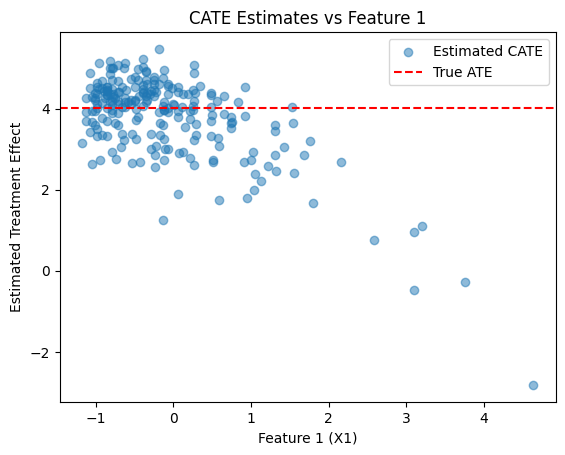

In [ ]:
# DML Estimator with Lasso for outcome model and RF for treatment model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

dml = DML(
    model_y=LassoCV(),                    # Outcome model
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10),      # Treatment model
    model_final=LinearRegression(),                # Final-stage model for effect estimation
    cv=3                                  # Cross-validation folds
)


dml.fit(Y_train, T_train, X=X_train)

# Predict CATE
cate = dml.effect(X_test)

# Evaluate Performance
true_effect = data['mu1'].values - data['mu0'].values  # True treatment effect
true_effect_test = true_effect[-len(X_test):]  # True ATE for the test set

# Compute Mean Squared Error for model quality
mse = mean_squared_error(true_effect_test, cate)
print(f"Mean Squared Error of CATE Estimates: {mse:.4f}")

# Interpretation
print("First 5 CATE estimates:", cate[:5])

# Visualizing results
plt.scatter(X_test[:, 0], cate, alpha=0.5, label='Estimated CATE')
plt.axhline(y=np.mean(true_effect), color='red', linestyle='--', label='True ATE')
plt.xlabel("Feature 1 (X1)")
plt.ylabel("Estimated Treatment Effect")
plt.legend()
plt.title("CATE Estimates vs Feature 1")
plt.show()


## CATEs should make sense
Like I said, the world of ML models is your oyster - so go ahead, mix and match models for the outcome and treatment steps.

⚠️ **But be warned:** Just because you can get creative doesn’t mean you should go wild without caution.


*   Make sure your models don’t overfit or underfit.

*   And remember, **CATEs should make sense**: They should roughly average to the ATE.

For example, check out the next graph —
what changed: I pretty much maxed out on the pparameters of the random forest model for the treatment model (intentionally) for it to overfit!


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


Mean Squared Error of CATE Estimates: 1.2957
First 5 CATE estimates: [3.25543719 4.35077872 4.43985983 2.86444896 4.70639099]


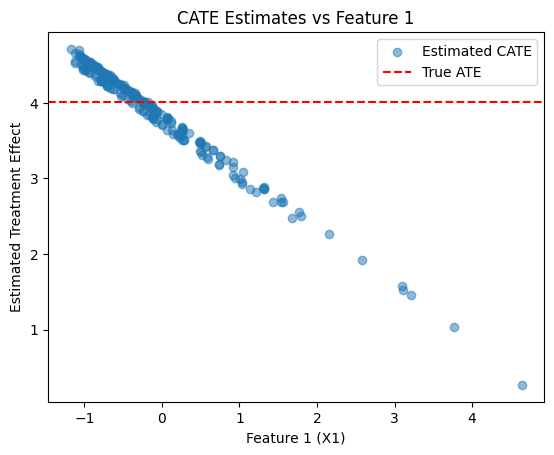

In [ ]:
dml = DML(
    model_y=LassoCV(),                    # Outcome model
    model_t=RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_leaf=10),      # Treatment model
    model_final=LassoCV(),                # Final-stage model for effect estimation
    cv=3                                  # Cross-validation folds
)


dml.fit(Y_train, T_train, X=X_train)

# Predict CATE
cate = dml.effect(X_test)

# Evaluate Performance
true_effect = data['mu1'].values - data['mu0'].values  # True treatment effect
true_effect_test = true_effect[-len(X_test):]  # True ATE for the test set

# Compute Mean Squared Error for model quality
mse = mean_squared_error(true_effect_test, cate)
print(f"Mean Squared Error of CATE Estimates: {mse:.4f}")

# Interpretation
print("First 5 CATE estimates:", cate[:5])

# Visualizing results
plt.scatter(X_test[:, 0], cate, alpha=0.5, label='Estimated CATE')
plt.axhline(y=np.mean(true_effect), color='red', linestyle='--', label='True ATE')
plt.xlabel("Feature 1 (X1)")
plt.ylabel("Estimated Treatment Effect")
plt.legend()
plt.title("CATE Estimates vs Feature 1")
plt.show()


# Next things coming:



*   More HTE estimation
*   Inference

<- Last updated: 3-16-2025